In [1]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# 描画
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import arviz as az
# plt.rcParams['font.family'] = 'Meiryo'

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

In [2]:
### データの読み込み ◆データファイル5.1 data-attendance-1.txtの構成
# A:バイト好き区分(1:好き), Score:学問の興味の強さ（0~200）, Y:授業の出席率（1年間）

data = pd.read_csv('./input/data-attendance-1.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (50, 3)


,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


# 分析の目的
- ２つの説明変数$A$と$Score$で応答変数$Y$がどれほど予測できるか知りたい
- それぞれの説明変数が出席率にどれほど影響しているかを知りたい

この解析結果を発表する場合、聴衆を納得させるにはどういう図を描いて発表資料を作成するべき？

## データ分布の確認

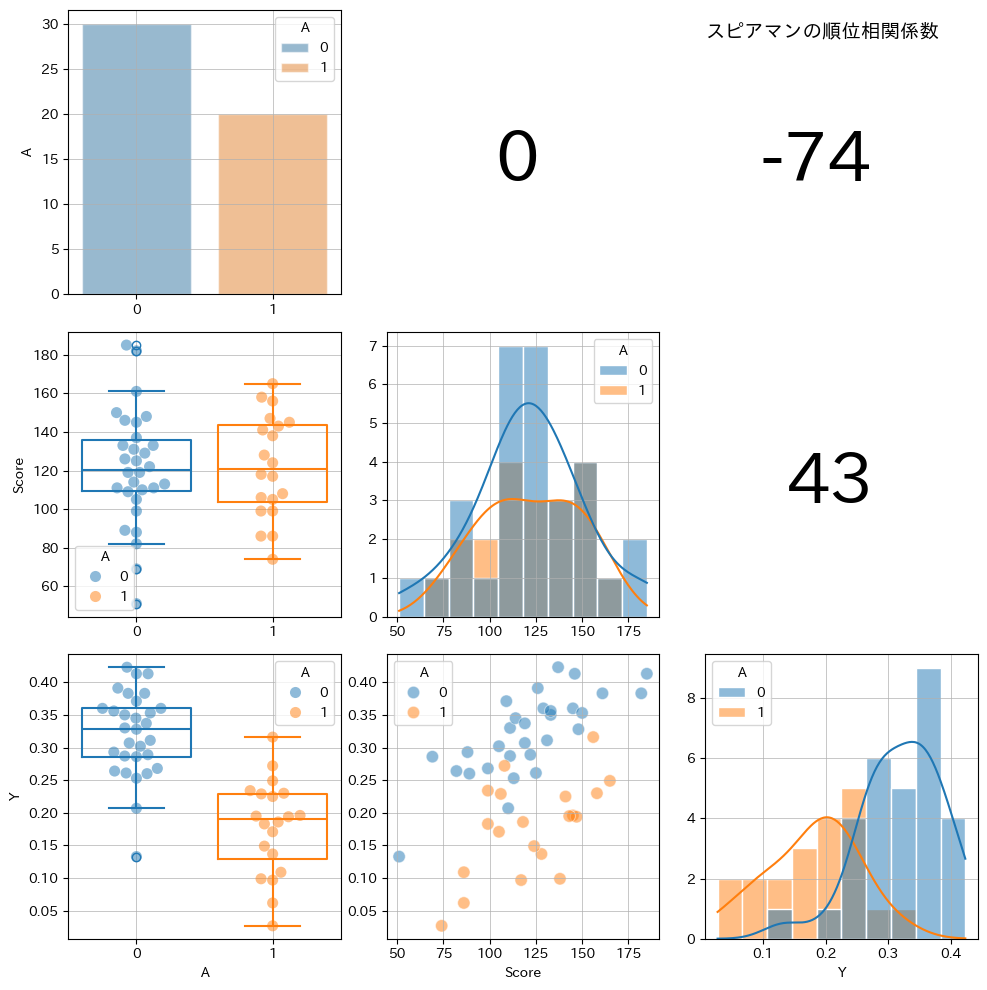

In [3]:
### 散布図行列の描画 ◆図5.1
# 凡例非表示・・・描画関数の引数に legend=None を追加する

## 描画領域の指定
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.ravel() # １次元でaxesを指定したいので

## 番地0,0：ヒストグラムの描画（棒グラフを使用）
bar_A = data.A.value_counts().sort_index()
sns.barplot(ax=ax[0], x=bar_A.index, y=bar_A, hue=bar_A.index, palette='tab10',
            alpha=0.5, ec='white')
ax[0].set(ylabel='A', xlabel=None)
ax[0].grid(lw=0.5)

## 番地0,1：スピアマンの順位相関係数の描画
ax[1].set_axis_off()
corr1, pval1 = stats.spearmanr(data.Score, data.A)
ax[1].text(x=0.4, y=0.4, s=round(corr1 * 100), fontsize=50)

## 番地0,2：スピアマンの順位相関係数の描画
ax[2].set_axis_off()
corr2, pval2 = stats.spearmanr(data.Y, data.A)
ax[2].text(x=0.2, y=0.4, s=round(corr2 * 100), fontsize=50)
ax[2].text(x=0, y=0.9, s='スピアマンの順位相関係数', fontsize=14)

## 番地1,0：箱ひげ図＋スウォームプロットの描画
sns.boxplot(ax=ax[3], x=data.A, y=data.Score, hue=data.A, fill=False,
            legend=None)
sns.swarmplot(ax=ax[3], x=data.A, y=data.Score, hue=data.A, size=8, alpha=0.5)
ax[3].set(xlabel=None)
ax[3].grid(lw=0.5)

## 番地1,1：ヒストグラムの描画
sns.histplot(ax=ax[4], data=data, x='Score', hue='A', bins=10, kde=True, 
             ec='white')
ax[4].set(xlabel=None, ylabel=None)
ax[4].grid(lw=0.5)

## 番地1,2：スピアマンの順位相関係数の描画
ax[5].set_axis_off()
corr3, pval3 = stats.spearmanr(data.Y, data.Score)
ax[5].text(x=0.3, y=0.4, s=round(corr3 * 100), fontsize=50)

## 番地2,0：箱ひげ図＋スウォームプロットの描画
sns.boxplot(ax=ax[6], x=data.A, y=data.Y, hue=data.A, fill=False,
            legend=None)
sns.swarmplot(ax=ax[6], x=data.A, y=data.Y, hue=data.A, size=8, alpha=0.5)
ax[6].grid(lw=0.5)

## 番地2,1：散布図の描画
sns.scatterplot(ax=ax[7], data=data, x='Score', y='Y', hue='A', size='A',
                sizes=(80, 80), alpha=0.5)
ax[7].set(ylabel=None)
ax[7].grid(lw=0.5)

## 番地2,2：ヒストグラムの描画
sns.histplot(ax=ax[8], data=data, x='Y', hue='A', bins=10, kde=True, ec='white')
ax[8].set(ylabel=None)
ax[8].grid(lw=0.5)

plt.tight_layout();

- scoreとYには線形関係がありそう。Aに関わらず。
- A=0/1の違いで、Yは如実に変わる。
→ AとScoreの線型結合でYが決まりそう（仮定・仮説）
  
$$
Y = b_1 + b_2A[n] + b_3Score[n] + \epsilon[n] 
$$

In [4]:
with pm.Model() as model:
    model.add_coord("data", values=data.index, mutable=True)

    Y = pm.ConstantData("Y", value=data["Y"].values, dims="data")
    A = pm.ConstantData("A", value=data["A"].values, dims="data")
    Score = pm.ConstantData("Score", value=data["Score"].values / 200, dims="data")

    ### prior
    b1 = pm.Uniform("b1", lower=-10, upper=10)
    b2 = pm.Uniform("b2", lower=-10, upper=10)
    b3 = pm.Uniform("b3", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)    # pm.HalfNormalでもいいはず

    ### 線形予測子
    mu = pm.Deterministic("mu", b1+b2*A+b3*Score, dims="data")

    ### 尤度関数
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=Y, dims="data")   ##← dims="data"忘れがち

    ### 計算値
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, dims="data")

# display(model)


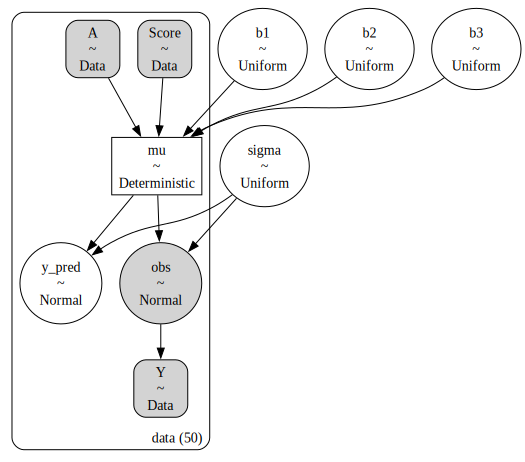

In [5]:
g = pm.model_to_graphviz(model)
display(g)

In [6]:
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                      nuts_sampler="numpyro", 
                      random_seed=123)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]

Running chain 0:  45%|████▌     | 900/2000 [00:01<00:00, 8980.87it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1095.69it/s]


In [7]:
# sampler 比較 ↑ numpyroがやはり早い
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                    #   nuts_sampler="numpyro", 
                      random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b2, b3, sigma, y_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [8]:
## rhat > 1.1の確認
# 設定
idata_in = idata 
threshold = 1.01

# 閾値を超えるR_hat個数を表示
print((az.rhat(idata_in) > threshold).sum())

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    b1       int64 8B 0
    b2       int64 8B 0
    b3       int64 8B 0
    mu       int64 8B 0
    sigma    int64 8B 0
    y_pred   int64 8B 0


In [9]:
# 事後統計量の確認
var_names = ["b1", "b2", "b3", "sigma", "mu"]
pm.summary(idata, hdi_prob=0.95, var_names=var_names, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,0.123,0.033,0.058,0.188,0.001,0.000,2570.718,2594.843,1.001
b2,-0.144,0.015,-0.174,-0.115,0.000,0.000,3635.322,3051.229,1.000
b3,0.326,0.052,0.221,0.427,0.001,0.001,2634.960,2753.801,1.001
sigma,0.052,0.006,0.042,0.063,0.000,0.000,1810.200,2406.171,1.002
mu[0],0.235,0.017,0.202,0.268,0.000,0.000,2686.456,3267.902,1.002
mu[1],0.215,0.013,0.189,0.241,0.000,0.000,3734.190,3547.764,1.001
mu[2],0.327,0.010,0.308,0.345,0.000,0.000,4076.724,3504.743,1.000
mu[3],0.119,0.015,0.090,0.148,0.000,0.000,3211.375,2877.807,1.001
mu[4],0.236,0.015,0.207,0.267,0.000,0.000,3374.070,3439.127,1.001
mu[5],0.340,0.010,0.320,0.360,0.000,0.000,4080.534,3322.990,1.000


In [10]:
# ベイズ信頼区間を含む、事後統計量

# mean, std, 2.5%, 25%, 50%, 75%, 97.5%
def make_stats_df(y: pd.DataFrame, probs_list=[2.5, 25, 50, 75, 97.5]):
    # probs = [2.5, 25, 50, 75, 97.5]
    columns = ["mean", "std"] + [str(s) + "%" for s in probs_list]
    quantiles = pd.DataFrame(np.percentile(y, probs_list, axis=0).T, index=y.columns)
    tmp_df = pd.concat([y.mean(axis=0), y.std(axis=0), quantiles], axis=1)
    tmp_df.columns = columns
    return tmp_df


num_axis1 = 9
y = pd.DataFrame(np.random.randn(100, num_axis1))  # 100行6列のデータ

# 計算例
# パーセンタイルの計算
probs = [2.5, 25, 50, 75]
percentiles0 = np.percentile(y, probs, axis=0)
percentiles1 = np.percentile(y, probs, axis=1)
print(percentiles0)
# print(percentiles1)

tmp_df = make_stats_df(y)
print(f"{tmp_df.shape=}")
assert tmp_df.shape[0] == num_axis1
display(tmp_df)

[[-1.81456262 -2.27230264 -1.58566675 -2.04720692 -2.13080778 -2.0763518
  -1.44104974 -1.72965974 -1.94936671]
 [-0.70078697 -0.85739027 -0.67065026 -0.86152035 -0.36131435 -0.53737912
  -0.49861995 -0.75167406 -0.48135999]
 [-0.01713401 -0.13686446 -0.01791449 -0.06935038  0.24403018  0.17629583
   0.03091618 -0.07478405  0.12522715]
 [ 0.65035564  0.63650081  0.61709844  0.60607495  0.76355559  0.7795563
   0.58020787  0.59472431  0.9028313 ]]
tmp_df.shape=(9, 7)


,mean,std,2.5%,25%,50%,75%,97.5%
0,-0.073828,0.971200,-1.814563,-0.700787,-0.017134,0.650356,1.745099
1,-0.115239,1.055337,-2.272303,-0.857390,-0.136864,0.636501,1.856017
2,-0.025729,0.890299,-1.585667,-0.670650,-0.017914,0.617098,1.721652
3,-0.087435,1.072292,-2.047207,-0.861520,-0.069350,0.606075,1.948437
4,0.140754,0.995108,-2.130808,-0.361314,0.244030,0.763556,1.919504
5,0.126091,1.011384,-2.076352,-0.537379,0.176296,0.779556,1.729987
6,0.054049,0.848290,-1.441050,-0.498620,0.030916,0.580208,1.650827
7,-0.019756,1.018155,-1.729660,-0.751674,-0.074784,0.594724,2.157577
8,0.134998,1.021896,-1.949367,-0.481360,0.125227,0.902831,1.930802


In [11]:
vars = ["b1", "b2", "b3", "mu", "sigma"]
param_samples = idata.posterior[vars].to_dataframe().reset_index(drop=True)
display(param_samples.head())
display(make_stats_df(param_samples).round(2))

,b1,b2,b3,mu,sigma
0,0.217585,-0.118341,0.179009,0.279343,0.057348
1,0.217585,-0.118341,0.179009,0.229025,0.057348
2,0.217585,-0.118341,0.179009,0.329465,0.057348
3,0.217585,-0.118341,0.179009,0.176217,0.057348
4,0.217585,-0.118341,0.179009,0.240660,0.057348


,mean,std,2.5%,25%,50%,75%,97.5%
b1,0.12,0.03,0.06,0.10,0.12,0.15,0.19
b2,-0.14,0.01,-0.17,-0.15,-0.14,-0.13,-0.11
b3,0.33,0.05,0.22,0.29,0.33,0.36,0.43
mu,0.26,0.08,0.11,0.20,0.28,0.33,0.42
sigma,0.05,0.01,0.04,0.05,0.05,0.06,0.06


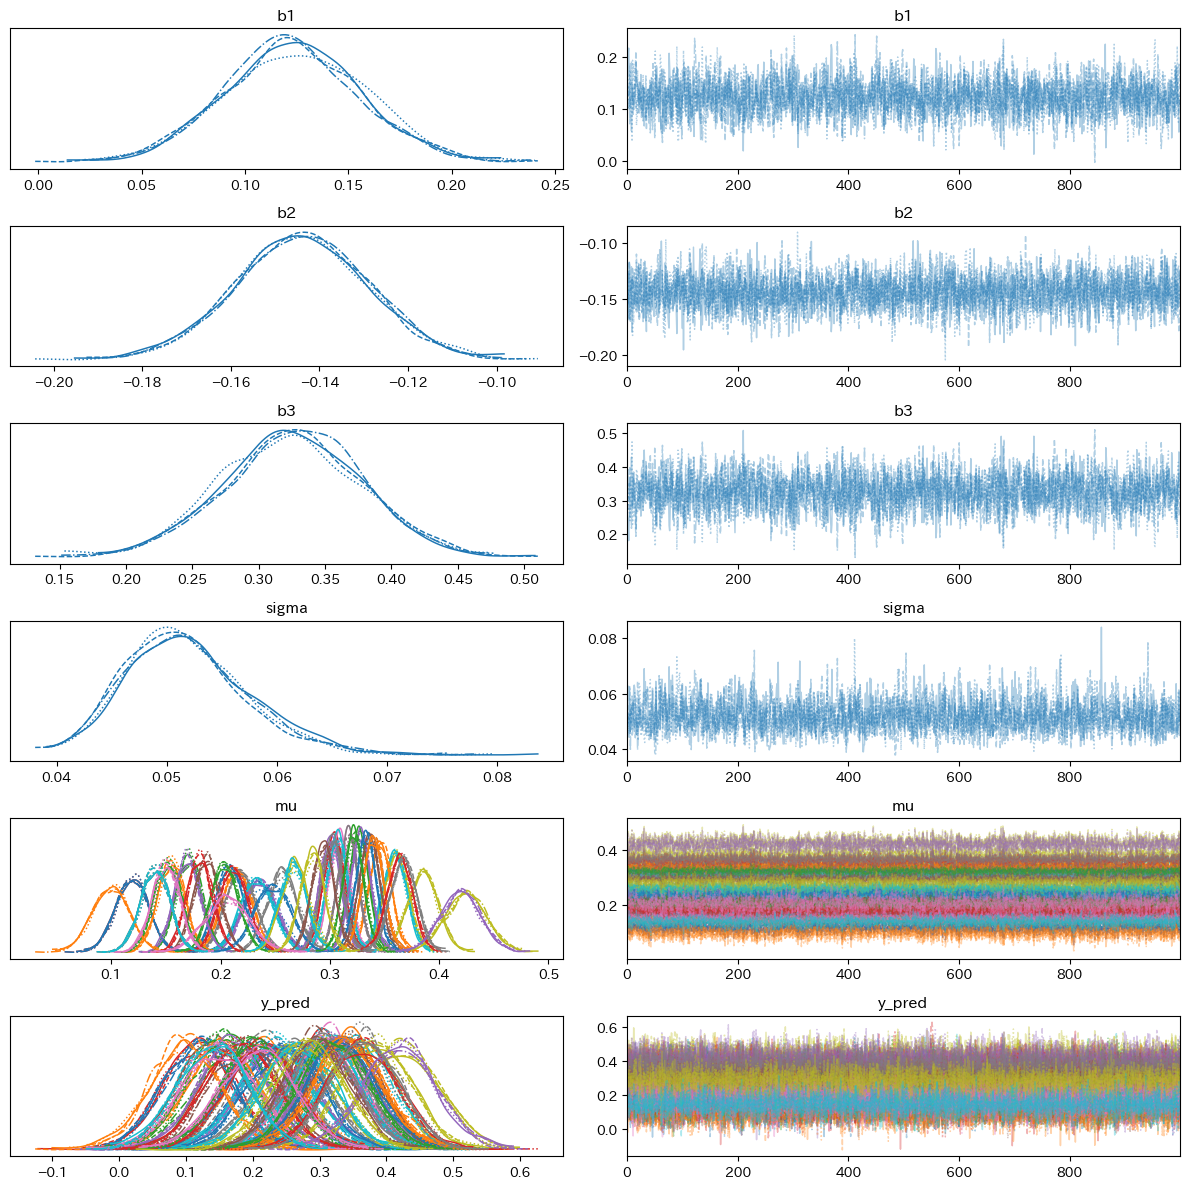

In [12]:
var_names = ["b1", "b2", "b3", "sigma", "mu", "y_pred"]
az.plot_trace(idata, compact=True, var_names=var_names)
plt.tight_layout()

In [13]:
rng = np.random.default_rng(seed=123)

x_scores = np.linspace(50, 200, 1001)
# mcmcサンプリングからb1~sigmaを取り出す
b1_samples = idata.posterior.b1.stack(sample=("chain", "draw")).data
b2_samples = idata.posterior.b2.stack(sample=("chain", "draw")).data
b3_samples = idata.posterior.b3.stack(sample=("chain", "draw")).data
sigma_samples = idata.posterior.sigma.stack(sample=("chain", "draw")).data

# アルバイト０とアルバイト１ごとに平均値muを計算（回帰式）
mu_A0 = np.array([b1_samples + b2_samples * 0 + b3_samples * x_score / 200 for x_score in x_scores])
mu_A1 = np.array([b1_samples + b2_samples * 1 + b3_samples * x_score / 200 for x_score in x_scores])

# アルバイト０とアルバイt１ごとに正規分布乱数でYの予測分布を計算
y_pred_A0 = rng.normal(loc=mu_A0, scale=sigma_samples)
y_pred_A1 = rng.normal(loc=mu_A1, scale=sigma_samples)

# 予測分布Yの80%のCI
y_pred_A0_80ci = np.quantile(y_pred_A0, q=[0.1, 0.9], axis=1)
y_pred_A1_80ci = np.quantile(y_pred_A1, q=[0.1, 0.9], axis=1)
print(f"{y_pred_A0_80ci.shape=}")
print(f"{y_pred_A1_80ci.shape=}")

y_pred_A0_80ci.shape=(2, 1001)
y_pred_A1_80ci.shape=(2, 1001)


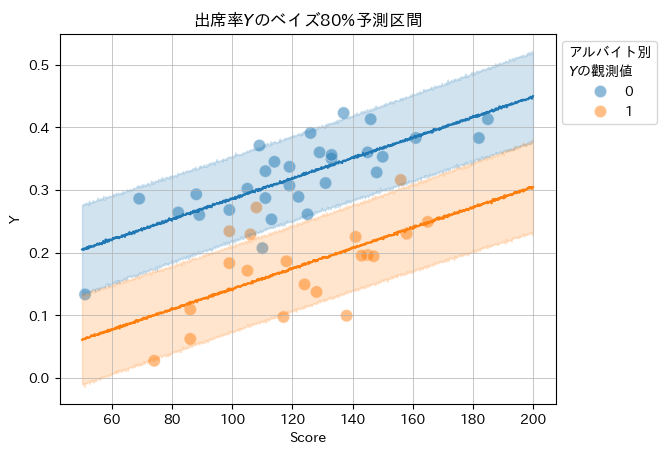

In [14]:
## 描画処理
# 観測値の散布図の描画
sns.scatterplot(data=data, x='Score', y='Y', hue='A', size='A', sizes=(80, 80),
                alpha=0.5)
# アルバイト0のyの予測分布の中央値を描画
plt.plot(x_scores, np.median(y_pred_A0, axis=1), color='tab:blue')
# アルバイト0のyの予測分布の80%CIを描画
plt.fill_between(x_scores, y_pred_A0_80ci[0], y_pred_A0_80ci[1],
                 color='tab:blue', alpha=0.2)
# アルバイト1のyの予測分布の中央値を描画
plt.plot(x_scores, np.median(y_pred_A1, axis=1), color='tab:orange')
# アルバイト1のyの予測分布の80%CIを描画
plt.fill_between(x_scores, y_pred_A1_80ci[0], y_pred_A1_80ci[1],
                 color='tab:orange', alpha=0.2)
# 修飾
plt.title('出席率$Y$のベイズ80%予測区間')
plt.legend(bbox_to_anchor=(1, 1), title='アルバイト別\n$Y$の觀測値')
plt.grid(lw=0.5);

分析の目的はなんだったか？$Y$を他の説明変数から予測すること。

重回帰のようなケースでは２次元平面で表現しきれない。よって以下の確認に焦点を置く。
- 実測値と予測値のプロット➡️実測値と予測値のずれ方に偏りがないか？を確認したい
    - 横軸に$Y[n]$, 縦軸に$Y$の予測値（説明変数から線形モデルで算出される値）
- 推定されたノイズの分布
    - 推定された$\epsilon$が$N(0, \sigma)$に従っているか？（モデル設計時の仮定通りか？）
        - $\epsilon=Y-\mu$
        - $\mu, \epsilon$：学生ごとに分布で得られる
    -　➡️今回は、$\mu$それぞれからMAP推定値を取り、その分布を見て正規分布に従っていそうかをみる。
        - ※ MAP推定値以外に、中央値・平均値などでも良い
- (optional) 残差プロット


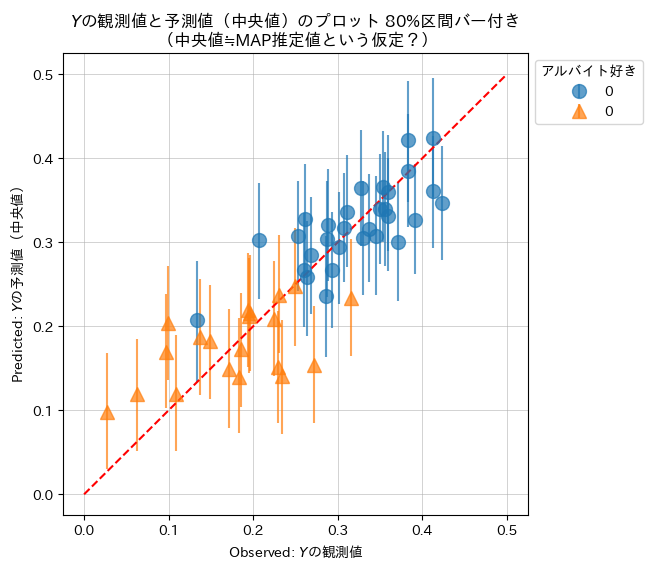

In [15]:
## 描画用データの作成：yPredの個人別の中央値と80%区間を算出
y_pred_samples = idata.posterior.y_pred.stack(sample=("chain", "draw")).data
# サンプリングデータの10%, 50% 90%パーセンタイルを算出してDF化
y_pred_with_quantile_df = pd.DataFrame(
    np.quantile(y_pred_samples, q=[0.1, 0.5, 0.9], axis=1).T,
    columns=["10%", "median", "90%"])
y_pred_df = pd.concat([data, y_pred_with_quantile_df], axis=1)

# errorbar向け：10%-中央値-90%の間の差を算出
y_pred_df["err_lower"] = y_pred_df["median"] - y_pred_df["10%"]
y_pred_df["err_upper"] = y_pred_df["90%"] - y_pred_df["median"]

# アルバイト0と1に分離
y_pred_A0 = y_pred_df.query("A==0")
y_pred_A1 = y_pred_df.query("A==1")

plt.figure(figsize=(6,6))
ax = plt.subplot()

ax.errorbar(y_pred_A0["Y"], y_pred_A0["median"],
            yerr=[y_pred_A0["err_lower"], y_pred_A0["err_upper"]],
            color="tab:blue", alpha=0.7, marker="o", ms=10, linestyle="none",
            label="0")
ax.errorbar(y_pred_A1["Y"], y_pred_A1["median"],
            yerr=[y_pred_A1["err_lower"], y_pred_A1["err_upper"]],
            color="tab:orange", alpha=0.7, marker="^", ms=10, linestyle="none",
            label="0")
# 対角線(y=x)の描画
ax.plot([0,0.5], [0,0.5], color="red", ls="--")
ax.set(xlabel="Observed: $Y$の観測値", ylabel="Predicted: $Y$の予測値（中央値）", 
       title="$Y$の観測値と予測値（中央値）のプロット 80%区間バー付き \n （中央値≒MAP推定値という仮定？）")
ax.legend(title="アルバイト好き", bbox_to_anchor=(1,1))
ax.grid(lw=0.4)

続いて、誤差$\epsilon[n]$の分布を描画

kdeplotを主に使用。MAP推定値をとるには、`get_lines()[i].get_data()`を利用

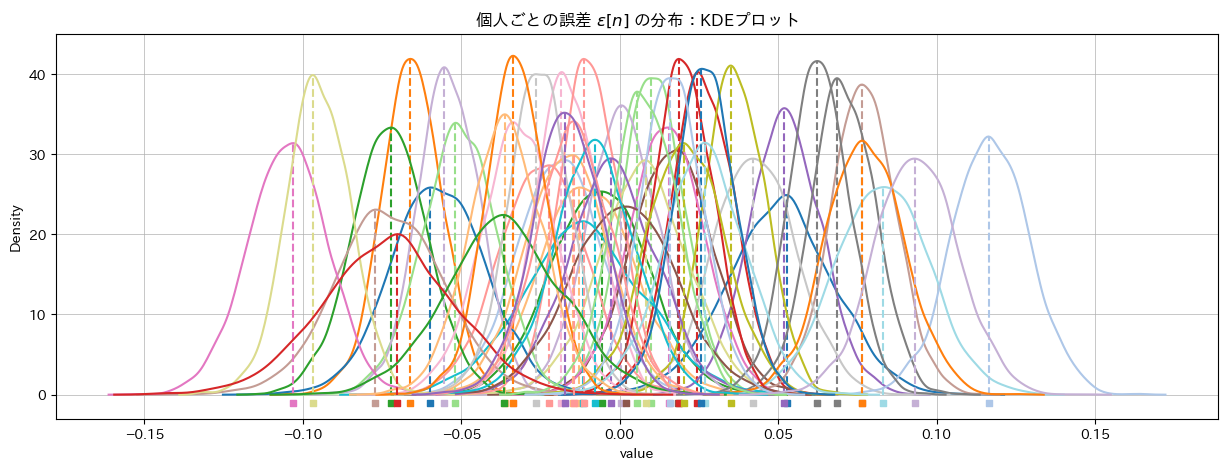

In [16]:
import matplotlib.cm as cm
### 個人ごとのεの分布の描画 ◆図5.4左

## 描画用データの作成 yPredの個人別の中央値と80%区間を算出
# MCMCサンプリングデータからyPredを取り出し
mu_samples = idata.posterior.mu.stack(sample=('chain', 'draw')).data
# εの算出： 観測値Y - muの事後分布サンプリングデータ
epsilon_samples = np.array([data.loc[i, 'Y'] - mu_sample
                            for i, mu_sample in enumerate(mu_samples)])

## 図5.4右の描画に利用するMAP推定値リストの初期化
map_plot = []

## 描画処理
# 描画領域の指定
plt.figure(figsize=(15, 5))
# 個人ごとのε（ε[n]）のKDEプロットの描画
for i, epsilon in enumerate(epsilon_samples):
    # 色の設定
    color = cm.tab20(i % 20)
    # x軸の値を設定
    x_ticks = np.linspace(epsilon.min(), epsilon.max(), 1001)
    # KDEプロットの描画
    kde_plot = sns.kdeplot(epsilon, color=color)
    # KDEプロットで描画した線から、x軸,y軸の値を取得
    kde_data = kde_plot.get_lines()[i].get_data()
    # KDEプロットのyの最大値のインデックスを取得
    kde_max_idx = kde_data[1].argmax()
    # KDEプロットのyの最大値≒MAP推定値の垂直線の描画
    plt.vlines(x=kde_data[0][kde_max_idx], ymin=0, ymax=kde_data[1][kde_max_idx],
               color=color, ls='--')
    # KDEプロットのyの最大値≒MAP推定値のy=0付近のx点の描画
    plt.scatter((kde_data[0][kde_max_idx]), (-1), marker='s', s=20, color=color)
    # 図5.4右用のMAP推定値の格納
    map_plot.append(kde_data[0][kde_max_idx])

# 修飾
plt.xlabel('value')
plt.title('個人ごとの誤差 $\epsilon[n]$ の分布：KDEプロット')
plt.ylim(-3, 45)
plt.grid(lw=0.5)

(200,)
0.0064885356346572


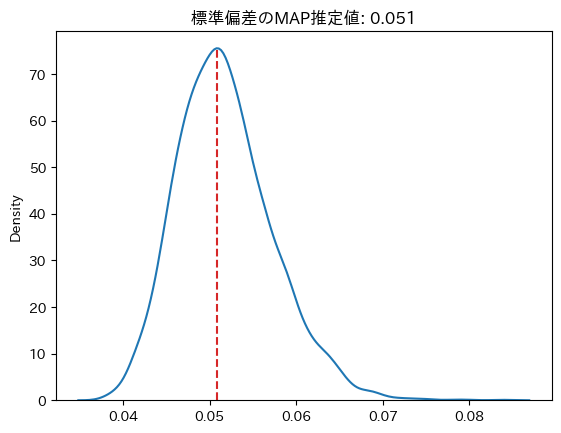

In [17]:
### σのKDEプロット
sigma_plot = sns.kdeplot(sigma_samples)
sigma_kde_data = sigma_plot.get_lines()[0].get_data()

x_values = sigma_kde_data[0]
y_values = sigma_kde_data[1] # sigmaのmap推定？

print(x_values.shape)
print(y_values[1])

sigma_map = x_values[y_values.argmax()]
plt.vlines(sigma_map, 0, y_values.max(), colors='tab:red', ls='--')
plt.title(f'標準偏差のMAP推定値: {sigma_map:.3f}');

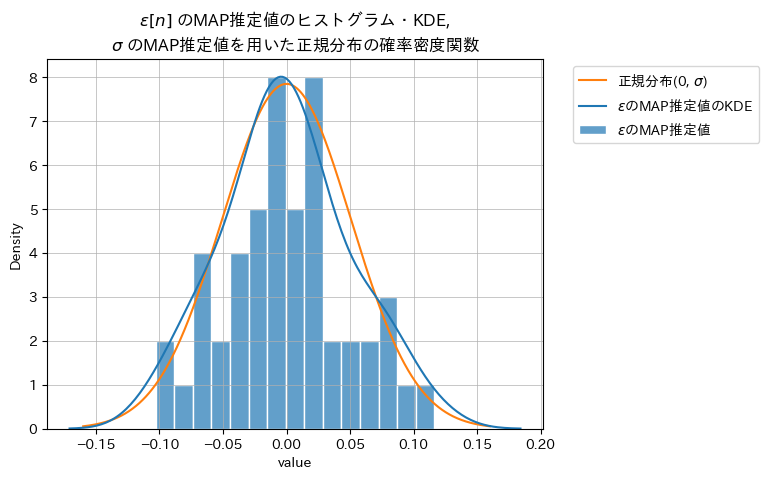

In [18]:
### εのMAP推定値のヒストグラム・KDEプロット、σのMAP推定値による正規分布 ◆図5.4右

## 描画用データの作成
# 正規分布のx軸の値を設定
xvals = np.linspace(-0.16, 0.16, 1001)
# 正規分布の確率密度関数の算出
yvals = stats.norm.pdf(xvals, loc=0, scale=sigma_map)

## 描画処理
# σのMAP推定値を用いた正規分布の確率密度関数の描画
plt.plot(xvals, yvals, color='tab:orange', label='正規分布(0, $\sigma$)')
# εのMAP推定値のKDEプロットの描画
sns.kdeplot(np.array(map_plot), color='tab:blue',
            label='$\epsilon$のMAP推定値のKDE')
# εのMAP推定値のヒストグラムの描画
sns.histplot(map_plot, bins=15, color='tab:blue', ec='white', alpha=0.7,
             label='$\epsilon$のMAP推定値')
# 修飾
plt.title('$\epsilon[n]$ のMAP推定値のヒストグラム・KDE,\n'
          '$\sigma$ のMAP推定値を用いた正規分布の確率密度関数')
plt.xlabel('value')
plt.legend(bbox_to_anchor=(1.45, 1))
plt.grid(lw=0.5);

# 結論
- 今回の分析は当てはまりも良く、うまく相関関係をとれた。
- また、説明変数は「時間的に先行している」から、従属変数（出席率$Y$）に対して因果関係をもつモデルとして考えて良さそう

## 注目するべきポイントと対応策
- 一部の学生（プロット１点に相当）が、ベイズ予測区間でなぜか大きい or y=xの直線から大きく外れているなど
- Observedの小さい点だけ、直線の上側（下側）にあるなどの偏り
- $\epsilon$の分布が（大きく）歪んでいる
➡️ 現場の説明変数だけでは説明できない原因が他にあるかもしれない。<u>（授業を欠席する理由が他にあるかもしれない）</u>

また、推定パラメータの散布図行列を見て、パラメータ間の相関関係など見ることもモデル改善のヒントになる